## Runs DE on different clusters. 
Does this over each donor and combined

In [1]:
# Input info
# se_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/SE.rds"
# sample_names = "preB,postB"
# outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/annotation_clones/genes_donors_DE_minPct_00_pval0.1"


#se_f = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_hg38_1_2/annotation_clones/SE.rds"
#outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/gff_hg38_1_2/annotation_clones/de_btwnclust_RNA/minPct_0.01_logfc0.1"
#sample_names =  "Input,Flt3l" 

se_f = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/allSamples.integrated.rds"
outdir = "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1"
sample_names = "CHIP_b1_Flt3l,CHIP_b1_Input,CHIP_b2_Input,cd34norm_Flt3l"


top_de = 3 
minPct = 0.1 
logfcthresh = 0.1 
p_thresh = 0.1
to_donors = FALSE

# Parameters
assay="RNA"
#minPct = 0.00
#logfcthresh = 0.1
#top_de = 3
#p_thresh=0.1
# test.use="wilcox"
# latent.vars = "NULL"

# Parallel processing
cores = 4

# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

#to_donors = TRUE


In [2]:
source(utils_script)
outdir = outdir
dir.create(outdir, showWarnings = FALSE)


Registered S3 method overwritten by 'spatstat.core':
  method          from
  formula.glmmPQL MASS

Attaching SeuratObject

Attaching sp

Warning message:
“package ‘dplyr’ was built under R version 4.1.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Loading required package: patchwork



In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "CHIP_b1_Flt3l"  "CHIP_b1_Input"  "CHIP_b2_Input"  "cd34norm_Flt3l"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")

library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.1.2”

Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from 

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
222734 features across 30062 samples within 2 assays 
Active assay: RNA (19039 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

## Run DE for  cluster vs all others 

In [6]:
btwnClust.outdir <- file.path(outdir, "btwnClust")
dir.create(btwnClust.outdir)


Warning message in dir.create(btwnClust.outdir):
"'/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust' already exists"


[1] "cluster 0"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj
IDS      5.801196e-304  0.3679540 0.465 0.229 1.104490e-299
NR4A2    9.247540e-287  0.4241926 0.561 0.325 1.760639e-282
YPEL5    4.887315e-251  0.3270661 0.492 0.267 9.304960e-247
MEF2C    4.650372e-242  0.4382385 0.758 0.577 8.853844e-238
ARHGEF40 3.231200e-230  0.2788613 0.361 0.171 6.151882e-226
C8orf86  1.043671e-228  0.2640822 0.329 0.148 1.987046e-224
[1] "saved cluster 0"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 1"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
COL23A1 1.842305e-224  0.5278823 0.741 0.548 3.507565e-220
LYZ     4.371203e-218  0.2417093 0.191 0.050 8.322333e-214
VCAN    1.321135e-199  0.4777798 0.417 0.214 2.515309e-195
RBM47   6.297163e-183  0.4770774 0.652 0.471 1.198917e-178
GAS7    2.104218e-177  0.4771058 0.744 0.586 4.006221e-173
EPB41L3 2.378405e-141  0.4088566 0.606 0.437 4.528245e-137
[1] "saved cluster 1"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 2"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
CDK6   2.136990e-81  0.2806957 0.834 0.752 4.068616e-77
ATP8B4 1.340609e-73  0.2796714 0.750 0.637 2.552385e-69
ETV6   7.353539e-70  0.2602576 0.862 0.781 1.400040e-65
NCALD  2.882234e-60  0.2747161 0.547 0.445 5.487485e-56
PCSK5  7.576411e-46  0.2187132 0.667 0.588 1.442473e-41
EMCN   2.113243e-44  0.2235946 0.514 0.425 4.023404e-40
[1] "saved cluster 2"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 3"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
FNDC3B  0.000000e+00  0.6145676 0.908 0.722  0.000000e+00
MPO     0.000000e+00  0.4785328 0.457 0.141  0.000000e+00
PRTN3   0.000000e+00  0.2717256 0.239 0.046  0.000000e+00
ELANE   0.000000e+00  0.2449951 0.232 0.044  0.000000e+00
LPO    1.709455e-257  0.4868397 0.529 0.253 3.254631e-253
AZU1   2.976275e-225  0.2134637 0.201 0.047 5.666529e-221
[1] "saved cluster 3"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 4"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
IL1RL1  0.000000e+00  0.4849378 0.395 0.114  0.000000e+00
CLC     0.000000e+00  0.2404445 0.154 0.013  0.000000e+00
IL18R1 1.093587e-248  0.5310783 0.474 0.205 2.082081e-244
UGT1A7 3.195369e-192  0.3561438 0.342 0.126 6.083663e-188
UGT1A9 6.815608e-188  0.3589522 0.353 0.135 1.297624e-183
IKZF2  1.053692e-182  0.5355327 0.644 0.417 2.006124e-178
[1] "saved cluster 4"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 5"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj
PROC      0.000000e+00  0.2044153 0.409 0.090  0.000000e+00
VIM       0.000000e+00  0.3436810 0.735 0.271  0.000000e+00
RGCC     8.131739e-304  0.2828585 0.598 0.209 1.548202e-299
ITM2C    7.187630e-299  0.2062240 0.552 0.178 1.368453e-294
DNASE1L3 1.568267e-294  0.1643558 0.340 0.082 2.985823e-290
WNT9A    2.167440e-286  0.1797337 0.456 0.135 4.126589e-282
[1] "saved cluster 5"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 6"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj
ABCC4    4.414580e-304  0.7118949 0.832 0.558 8.404920e-300
ZFPM1    5.895984e-226  0.5321607 0.593 0.294 1.122536e-221
SOS1     3.330582e-187  0.5412651 0.653 0.394 6.341094e-183
ST8SIA6  4.146765e-176  0.4862795 0.632 0.374 7.895025e-172
C1orf116 7.747201e-135  0.1983481 0.232 0.075 1.474990e-130
ZBTB16   1.744080e-130  0.4373213 0.806 0.621 3.320554e-126
[1] "saved cluster 6"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 7"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
HBB     1.552248e-178  0.1762902 0.114 0.013 2.955326e-174
DNAJC6  5.567563e-159  0.6333962 0.597 0.341 1.060008e-154
ZFPM1   8.150161e-138  0.5677328 0.545 0.302 1.551709e-133
GAS7    6.176564e-126 -0.5748188 0.306 0.620 1.175956e-121
AMMECR1 3.822402e-121  0.5571769 0.546 0.332 7.277471e-117
DOCK10  9.887045e-111 -0.5402436 0.390 0.671 1.882395e-106
[1] "saved cluster 7"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 8"
              p_val avg_log2FC pct.1 pct.2    p_val_adj
SYNJ2  1.955220e-98 -0.1130482 0.161 0.526 3.722544e-94
RAI1   3.303521e-96 -0.1335945 0.159 0.519 6.289574e-92
OSBPL3 7.431669e-95 -0.1594654 0.193 0.571 1.414916e-90
CLCN3  1.904088e-94 -0.1200141 0.114 0.434 3.625193e-90
ESYT1  8.415310e-94 -0.1363354 0.116 0.437 1.602191e-89
DPYSL2 5.136190e-93 -0.1400483 0.135 0.469 9.778792e-89
[1] "saved cluster 8"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 9"
         p_val avg_log2FC pct.1 pct.2 p_val_adj
FOXO6        0  0.6299042 0.501 0.146         0
IQSEC1       0  1.0649853 0.892 0.676         0
DUSP26       0  0.3808302 0.298 0.044         0
FAM163B      0  0.3353153 0.293 0.026         0
CD81         0  0.5186587 0.410 0.084         0
ARHGEF25     0  0.3801043 0.320 0.049         0
[1] "saved cluster 9"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 10"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
ATP10A 1.233848e-140  0.5997641 0.671 0.407 2.349124e-136
KCNQ3  1.951955e-126  0.5139704 0.606 0.344 3.716328e-122
RB1    4.824891e-124  0.5513916 0.801 0.610 9.186111e-120
IPCEF1 2.723339e-116  0.5338571 0.727 0.500 5.184964e-112
CMKLR1 4.774603e-109  0.4295602 0.459 0.224 9.090366e-105
FGF6   1.225040e-103  0.2402703 0.202 0.057  2.332354e-99
[1] "saved cluster 10"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 11"
               p_val avg_log2FC pct.1 pct.2     p_val_adj
MPO    3.830509e-219  0.4057640 0.488 0.155 7.292906e-215
FNDC3B 1.110880e-212  0.6598133 0.955 0.729 2.115004e-208
ELANE  2.529915e-152  0.1900956 0.232 0.053 4.816706e-148
PRTN3  4.352241e-146  0.1813998 0.233 0.055 8.286233e-142
LPO    2.945705e-131  0.3845266 0.559 0.264 5.608328e-127
ATP8B4 8.436621e-130  0.5109382 0.888 0.639 1.606248e-125
[1] "saved cluster 11"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 12"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
PHTF1   1.075800e-192  0.5827920 0.620 0.240 2.048215e-188
ANKRD61 1.419218e-172  0.1453156 0.169 0.022 2.702049e-168
CXADR   1.460343e-143  0.3870942 0.507 0.185 2.780348e-139
GDF10   3.769014e-137  0.2265864 0.266 0.063 7.175825e-133
GYPB    2.916165e-118  0.1790272 0.230 0.053 5.552086e-114
C2orf66 1.208154e-117  0.1396481 0.154 0.026 2.300204e-113
[1] "saved cluster 12"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 13"
                p_val avg_log2FC pct.1 pct.2    p_val_adj
MBNL1    1.412784e-39 -0.5256141 0.441 0.745 2.689799e-35
CDK6     2.178859e-38 -0.5208481 0.490 0.765 4.148329e-34
ZEB2     1.450914e-32 -0.4627920 0.445 0.710 2.762395e-28
FNDC3B   1.032302e-31 -0.4764159 0.498 0.742 1.965400e-27
CHST11   2.704158e-31 -0.4239526 0.600 0.831 5.148447e-27
ARHGAP26 4.387902e-30 -0.4273266 0.598 0.816 8.354126e-26
[1] "saved cluster 13"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 14"
                p_val avg_log2FC pct.1 pct.2     p_val_adj
CCL2    2.667696e-204  0.2951526 0.255 0.021 5.079026e-200
FPR3    4.327181e-134  0.5563406 0.500 0.115 8.238520e-130
ZNF577   1.436422e-75  0.4129083 0.454 0.140  2.734804e-71
SLCO2B1  1.042038e-66  0.5139273 0.579 0.245  1.983936e-62
FPR1     9.539111e-65  0.4856046 0.510 0.194  1.816151e-60
MYO1E    9.901236e-62  0.5690519 0.726 0.393  1.885096e-57
[1] "saved cluster 14"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 15"
                  p_val avg_log2FC pct.1 pct.2    p_val_adj
NCR2       5.667755e-33  0.2813705 0.235 0.075 1.079084e-28
RGS1       1.229176e-23  0.2857758 0.233 0.089 2.340228e-19
FNDC3B     1.023001e-22 -0.5381130 0.580 0.740 1.947692e-18
LDLRAD4    1.425740e-16  0.3479391 0.807 0.727 2.714467e-12
TNFRSF4    1.913603e-15  0.1049589 0.110 0.034 3.643309e-11
CSGALNACT1 1.219554e-14  0.4004679 0.658 0.528 2.321908e-10
[1] "saved cluster 15"


Warning message:
"Only one identity present, the expression values will be not scaled"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "cluster 16"
               p_val avg_log2FC pct.1 pct.2    p_val_adj
PLCH2   5.959302e-61  0.3204577 0.672 0.122 1.134592e-56
FRMD1   1.968850e-57  0.1222465 0.395 0.052 3.748493e-53
VWA5B1  2.302495e-53  0.1034960 0.445 0.067 4.383720e-49
COLEC11 3.539582e-52  0.1204763 0.504 0.084 6.739011e-48
STKLD1  5.782896e-51  0.1203111 0.580 0.107 1.101006e-46
ASB18   7.796410e-51  0.1139653 0.395 0.057 1.484359e-46
[1] "saved cluster 16"


Warning message:
"Only one identity present, the expression values will be not scaled"
The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



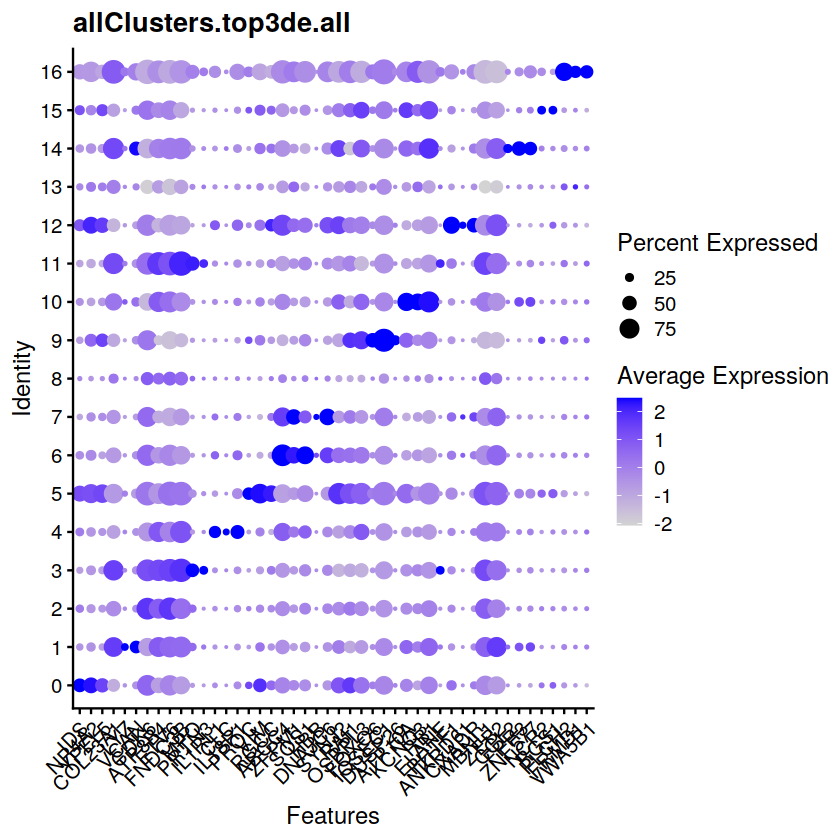

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



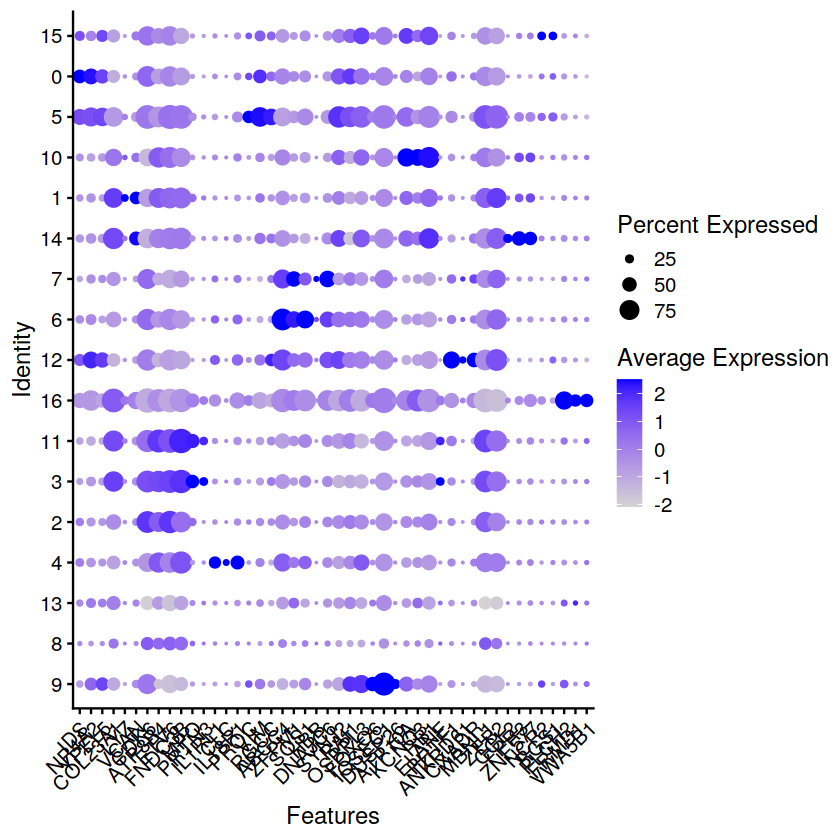

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



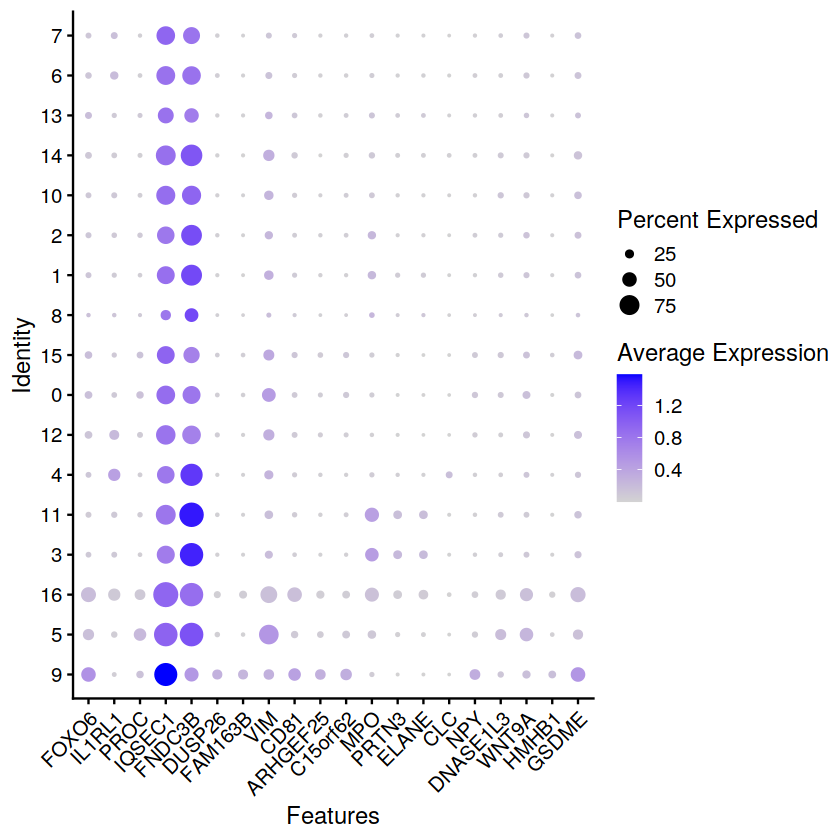

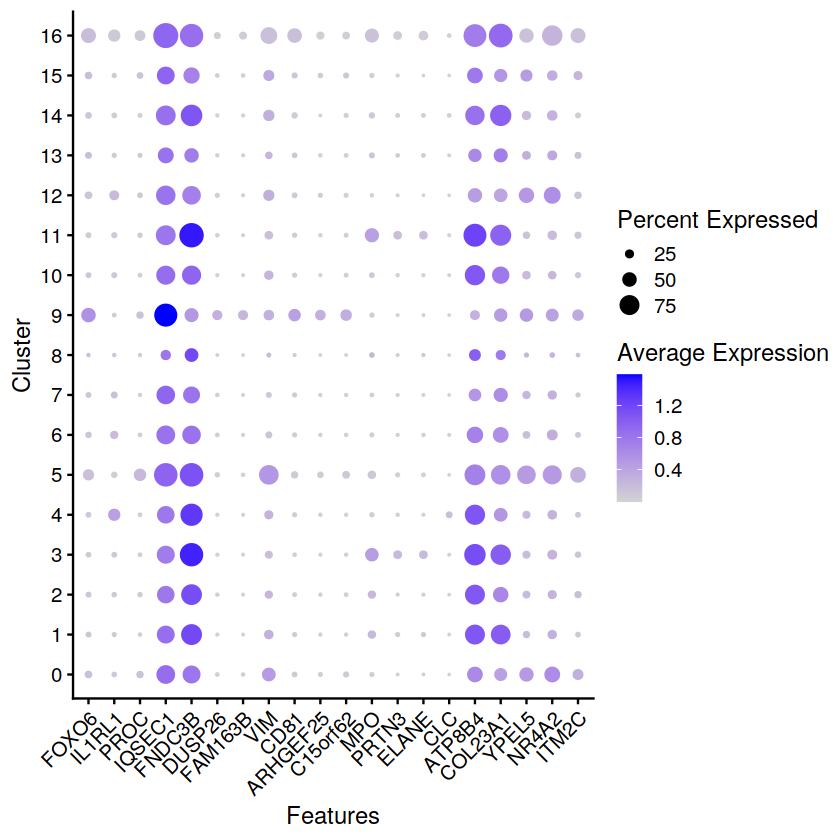

In [7]:
curr.outdir <- btwnClust.outdir

cluster.ids <- sort(unique(se$seurat_clusters))
Idents(se) <- se$seurat_clusters

all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                          row.names=row.names(se))
all.names.sig <- c()
for (id1 in cluster.ids){ #or however many clusters you have
try({
    print(paste("cluster", id1))
    response <- FindMarkers(
                  object = se,
                  ident.1 = id1, #"CD4 Naive",
                  min.pct = minPct, logfc.threshold=logfcthresh,
                  test.use = 'wilcox', latent.vars = NULL
                )
    print(head(response))
    #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
    
    
    print(paste('saved cluster', id1))
    response <- response %>% dplyr::arrange(p_val)
    response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))    
    write.csv(response,
              file=file.path(curr.outdir, paste0("cluster",id1,".DE.csv")), quote=F)
    
    curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
    
    
    names.sig <- rownames(curr.sig)
    se.filt <- subset(se, seurat_clusters == id1)
    
    # Add to all pvals
    all.names.sig <- c(all.names.sig, head(names.sig, top_de))
    all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH
    de.plots(se.filt, names.sig, curr.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T)
    
})
}


all.names.sig <- unique(all.names.sig)
#de.plots(se, all.names.sig, curr.outdir, curr.name="allClusters.top3de", max.size=15)
de.plots(se, all.names.sig, curr.outdir, curr.name="allClusters.top3de.all", max.size=length(all.names.sig))


dot <- DotPlot(se, scale=T,
               features = all.names.sig, #head(all.names.sig, 20), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.top3de.all.png"))
ggsave(file.path(curr.outdir, "allClusters.top3de.all.pdf"))

## b) averaged top p-values (only average ones that were DE)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.png"))
ggsave(file.path(curr.outdir, "allClusters.pvalsOrdered.scaleF.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



all.pvals.nafill <- all.pvals
all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
dot <- DotPlot(se, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=F) + RotatedAxis() + ylab("Cluster")
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.png"))
ggsave(file.path(btwnClust.outdir,
                 "allClusters.ovalsOrderedNA.scaleF.pdf"))
dot

In [8]:
btwn_embeddings <- file.path(btwnClust.outdir, "embeddings")
dir.create(btwn_embeddings)


featplot <- function(name.sig, se, curr.outdir){
    feat <- FeaturePlot(se,  features=name.sig)
    ggsave(plot=feat,
           file=file.path(curr.outdir, paste0(name.sig,".embedFeat.top.png")))
    }

sapply(all.names.sig, FUN=featplot, se=se, curr.outdir=btwn_embeddings)

Warning message in dir.create(btwn_embeddings):
"'/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings' already exists"
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image


IDS 
    "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/IDS.embedFeat.top.png" 
                                                                                                                                                                             NR4A2 
  "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/NR4A2.embedFeat.top.png" 
                                                                                                                                                                             YPEL5 
  "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/YPEL5.embedFeat.top.png" 
                                                                                                                                                                           COL23A1 
"/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/COL23A1.embedFeat.top.png" 
                                                                                                                                                                               LYZ 
    "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/LYZ.embedFeat.top.png" 
                                                                                                                                                                              VCAN 
   "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/VCAN.embedFeat.top.png" 
                                                                                                                                                                              CDK6 
   "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/CDK6.embedFeat.top.png" 
                                                                                                                                                                            ATP8B4 
 "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/ATP8B4.embedFeat.top.png" 
                                                                                                                                                                              ETV6 
   "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/ETV6.embedFeat.top.png" 
                                                                                                                                                                            FNDC3B 
 "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/FNDC3B.embedFeat.top.png" 
                                                                                                                                                                               MPO 
    "/data/Mito_Trace/output/aggregate/CHIP_aggr/v04_no_ChA1/data/annotation/gff_A2/mergedSamples/de_btwnclust_RNA/minPct_0.1_logfc0.1/btwnClust/embeddings/MPO.embedFeat.top.png" 
                                                                                                                                                                             PRTN3 
  "/data/Mito_Trace/output/aggregat

---

---

---

# Run cluster vs all for each donor

In [9]:
if(to_donors){
    source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")

    btwnClust.sepDons.outdir <- file.path(outdir, "btwnClust_sepDons")
    dir.create(btwnClust.sepDons.outdir)
    curr.outdir <- btwnClust.sepDons.outdir

    # Setup Idents to include the condition, clusters and donor
    se$clust_donor <- as.factor(apply(se[[]][ , c( "seurat_clusters", "donor") ] , 1 , paste , collapse = "_" ))
    Idents(se) <- se$clust_donor
    don.ids <- levels(se$donor)
    cluster.ids <- sort(unique(se$seurat_clusters))

    all.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                              row.names=row.names(se))
    all.names.sig <- c()

    for (clust in cluster.ids){ #or however many clusters you have
        clust.names.sig <- c()
        print("cluster")
        print(clust)
        clust.pvals <- data.frame(matrix(nrow=dim(se)[1],ncol=0),
                                  row.names=row.names(se))
        clust.outdir <- file.path(curr.outdir, paste0("clust", clust))
        dir.create(clust.outdir)
        for (don in don.ids){
            try({
                if (clust == "None" | don == "None"){
                    print("clust or don is none")
                    next
                }
                id1 = paste0(clust, "_", don)
                print("ID1")
                print(id1)
                response <- FindMarkers(
                              object = se,
                              ident.1 = id1, #"CD4 Naive",
                              min.pct = minPct,
                              test.use = 'wilcox', latent.vars = NULL
                            )

                #write.csv(response, file=file.path(clust_outdir, paste0("cluster_",i,"vsAll.DE.csv")))
                response <- response %>% dplyr::arrange(p_val)
                response$p_val_adj_BH <- stats::p.adjust(response$p_val, method = "BH", n = length(response$p_val))    
                print(head(response))
                write.csv(response,
                          file=file.path(clust.outdir, paste0("clust",clust,"donor", don, ".DE.csv")), quote=F)

                curr.sig <- response %>% dplyr::filter(p_val_adj_BH<p_thresh)
                names.sig <- rownames(curr.sig)
                se.filt <- subset(se, idents = id1)
                de.plots(se.filt, names.sig, clust.outdir, curr.name=id1, max.size=10, to.heat=T,to.vln=T)

                # Add to all pvals
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,id1] <- curr.sig$p_val_adj_BH
                clust.names.sig <- c(clust.names.sig, head(names.sig, top_de))
                clust.pvals[names.sig, don] <- curr.sig$p_val_adj_BH
            })
        }
        if (clust != "None"){
            se.filt <- subset(se, subset = seurat_clusters == clust & donor != "None")
            Idents(se.filt) <- se.filt$donor
            tryCatch(wrap.plot.over.all(se.filt, clust.outdir, clust.pvals, clust.names.sig, 
                                        name=paste0("cluster",clust,"topDonorDE.split_donors")),
                     error = function(e) print(e))
            }
    }
    
    tryCatch(wrap.plot.over.all(se, curr.outdir, all.pvals, all.names.sig, name="allClusters"),
             error = function(e) print(e))
}


# all.names.sig <- unique(all.names.sig)
# de.plots(se, all.names.sig, curr.outdir, curr.name="combinedDonors.allClusters", max.size=15)

# dot <- DotPlot(se, scale=FALSE,
#                features = head(all.names.sig,20), 
#                cluster.idents=T) + RotatedAxis()
# dot
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.top3de.png"))
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.top3de.pdf"))

# ## b) averaged top p-values (only average ones that were DE)

# sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
# dot <- DotPlot(se, scale=F,
#                features = names(head(sig.all.ordered,20)), 
#                cluster.idents=T) + RotatedAxis()
# dot
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.pvalsOrdered.scaleF.png"))
# ggsave(file.path(curr.outdir, "combinedDonors.allClusters.pvalsOrdered.scaleF.pdf"))
# #de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)



# all.pvals.nafill <- all.pvals
# all.pvals.nafill[,] <- -log10(zoo::na.fill(all.pvals,1))

# sig.all.ordered <- sort(rowMeans(all.pvals.nafill), decreasing=T)
# dot <- DotPlot(se, scale=F,
#                features = head(names(sig.all.ordered),20), 
#                cluster.idents=F) + RotatedAxis() + ylab("Cluster")
    
# ggsave(file.path(btwnClust.sepDons.outdir,
#                  "combinedDonors.allClusters.ovalsOrderedNA.scaleF.png"))
# ggsave(file.path(btwnClust.sepDons.outdir,
#                  "combinedDonors.allClusters.ovalsOrderedNA.scaleF.pdf"))
# dot

In [11]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.25.0             RColorBrewer_1.1-3       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.3            data.table_1.14.2        
 [7] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
 [9] AnnotationFilter_1.18.0   GenomicFeatures_1.46.1   
[11] 